In [58]:
import torch
import torchvision.models as models
import torch.nn as nn

# Make the same model as in the saved version
model_transfer = models.alexnet(pretrained=True, progress=True)

# Freeze parameters
for param in model_transfer.parameters():
    param.requires_grad = False

# Add the classifier
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
    #('d1',   nn.Dropout(0.1, inplace=False)),
    ('fc1',  nn.Linear(9216, 1000, bias=True)),
    ('relu', nn.ReLU(inplace=True)),
    #('d2',   nn.Dropout(0.1, inplace=False)),
    ('fc2',  nn.Linear(1000, 133, bias=True)),
    ('out',  nn.LogSoftmax(dim=1)), #no need in this layer if CrossEntropyLoss is used as criterion, see below.
    ]))
# Replace the classifier
model_transfer.classifier = classifier
model_transfer

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=1000, bias=True)
    (relu): ReLU(inplace=True)
    (fc

In [61]:
model_transfer = models.resnet50(pretrained=True, progress=True)
# Freeze parameters
for param in model_transfer.parameters():
    param.requires_grad = False

# Replace just the last layer
#model_transfer.fc = classifier
model_transfer.fc = nn.Linear(2048, 133, bias=True)
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [138]:
# Load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [119]:
# Loaders
from torchvision import datasets, transforms

batch_size = 42 # I like 42
num_workers = 0 # I do not want parallel downloads.

data_dir = 'dogImages'
#
train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomRotation(15),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomGrayscale(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                       ])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                      ])


train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data  = datasets.ImageFolder(data_dir + '/test' , transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)

# prepare data loaders 
#train_loader = torch.utils.data.DataLoader(train_data, batch_size=42, shuffle=True)
#test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=42)
#valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=42)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)


loaders_scratch = {'train':train_loader, 'test': test_loader, 'valid': valid_loader}
loaders_transfer = loaders_scratch

In [120]:
import torch.optim as optim
# Use the CrossEntropyLoss and Adam again
criterion_transfer = nn.CrossEntropyLoss()
#criterion_transfer = nn.NLLLoss()
# Train only the classifier parameters, keep feature parameters frozen
#optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

In [121]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [143]:
# Test
import numpy as np

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.550698


Test Accuracy: 83% (696/836)


In [123]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
#class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]
print(class_names[:10])
print(len(class_names))

['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute', 'American eskimo dog', 'American foxhound', 'American staffordshire terrier', 'American water spaniel', 'Anatolian shepherd dog']
133


In [139]:
# Follow the steps for VGG16_predict()

from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    input_image = Image.open(img_path)
    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    
    with torch.no_grad():
        output = model_transfer(input_batch)
    
    class_ind = torch.argmax(output[0]).item() 
    breed = class_names[class_ind]
    
    return breed

path: lfw/Patrice_Chereau/Patrice_Chereau_0002.jpg


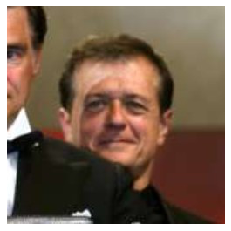

It is Boston terrier
path: dogImages/valid/091.Japanese_chin/Japanese_chin_06214.jpg


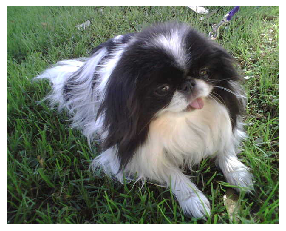

It is Japanese chin


In [140]:
# Test on random images
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt                        
%matplotlib inline                               


# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

nr = np.random.randint(0,100)
path = [human_files[nr], dog_files[nr]]
for p in path:
    print('path:',p)
    plt.imshow(Image.open(p))
    plt.axis('off')
    plt.show()
    print('It is',predict_breed_transfer(p))

path: /home/vb/Programming/Udacity/Lesson_6/fast-style-transfer-master/Begun_Github.jpeg


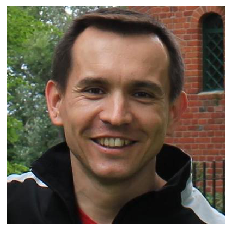

It is Boston terrier
path: /home/vb/Programming/Udacity/Lesson_6/fast-style-transfer-master/Me_1.png


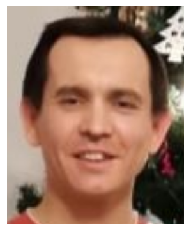

It is Bull terrier
path: /home/vb/Programming/Udacity/Lesson_6/fast-style-transfer-master/G_1.png


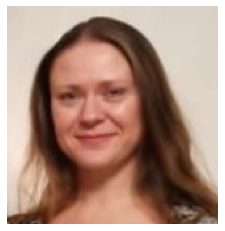

It is English springer spaniel
path: /home/vb/Programming/Udacity/Lesson_6/fast-style-transfer-master/Me_2.png


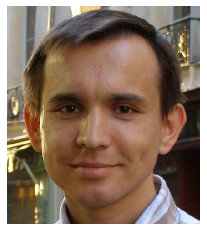

It is Xoloitzcuintli
path: /home/vb/Programming/Udacity/Lesson_6/fast-style-transfer-master/G_2.png


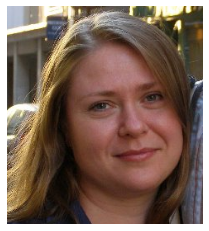

It is English springer spaniel
path: /home/vb/Programming/Udacity/Lesson_6/fast-style-transfer-master/Me_3.png


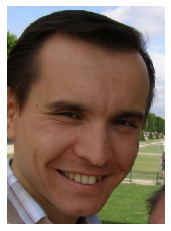

It is Bull terrier
path: /home/vb/Programming/Udacity/Lesson_6/fast-style-transfer-master/G_3.png


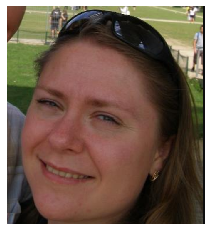

It is Bull terrier
path: /home/vb/Programming/Udacity/Lesson_6/fast-style-transfer-master/P_1.png


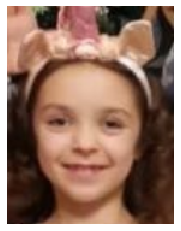

It is Bull terrier
path: /home/vb/Programming/Udacity/Lesson_6/fast-style-transfer-master/Cat_1.png


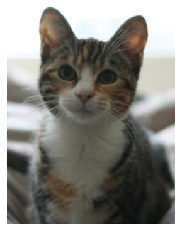

It is Japanese chin


In [145]:
# Check on my photo
path_0 = '/home/vb/Programming/Udacity/Lesson_6/fast-style-transfer-master/'
path_1 = ['Begun_Github.jpeg','Me_1.png','G_1.png','Me_2.png','G_2.png','Me_3.png','G_3.png','P_1.png','Cat_1.png']
for p1 in path_1:
    p = path_0+p1
    print('path:',p)
    plt.imshow(Image.open(p))
    plt.axis('off')
    plt.show()
    print('It is',predict_breed_transfer(p))